# Notebook para o PAN - Atribuição Autoral - 2018

In [1]:
%matplotlib inline
#python basic libs
import os;
from os.path import join as pathjoin;

import warnings
import re;
import glob;
import json;
import codecs;
from collections import defaultdict;
import pprint;


from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
from pandas.plotting import scatter_matrix;
import matplotlib.pyplot as plt;
import random;

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#preprocessing and transformation
from sklearn.preprocessing import normalize, MaxAbsScaler, MinMaxScaler;
from sklearn.preprocessing import LabelBinarizer;
from sklearn.decomposition import PCA;
from sklearn.metrics.pairwise import cosine_similarity;


from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import RFE,SelectFpr,SelectPercentile, chi2;

#
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;


In [2]:
import seaborn as sns;
sns.set(color_codes=True);

In [3]:
import platform; print(platform.platform())
print("NumPy", np.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)
print("seaborn", sns.__version__)

Darwin-18.2.0-x86_64-i386-64bit
NumPy 1.15.4
SciPy 1.2.0
Scikit-Learn 0.20.2
seaborn 0.9.0


In [4]:
np.set_printoptions(precision=4)
pd.options.display.float_format = '{:,.4f}'.format

In [42]:
from skleanExtensions import DenseTransformer

### paths configuration

In [5]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [6]:
import pan;

In [7]:
problems = pan.readCollectionsOfProblems(inputDir);

In [8]:
problems[0]

{'problem': 'problem00001', 'language': 'en', 'encoding': 'UTF-8'}

In [11]:
for index,problem in enumerate(problems):
    unk_folder, candidates_folder = pan.readProblem(inputDir, problem['problem']); 
    problem['candidates_folder_count'] = len(candidates_folder);
    problem['candidates'] = [];
    for candidate in candidates_folder:
        problem['candidates'].extend(pan.read_files(pathjoin(inputDir, problem['problem']),candidate));
    
    problem['unknown'] = pan.read_files(pathjoin(inputDir, problem['problem']),unk_folder);    

In [12]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[(graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[(after all, his best friends. And what in the..."
1,"[(a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[(“Potter was attractive,” Draco thought, sigh..."
2,[(qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[(son réveil. Sa main pulse et Draco frotte l'...
3,[(. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[(abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[(Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[(– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[(Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[(così la tua vista, Moony?\n– Cercavo di esse..."
6,[(zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[(dawniej pełna radości i ciepła, a teraz wiec..."
7,"[(Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[(, uderzającego o żebra niczym dzwon- niemal ..."
8,[(pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[(–La nariz puntiaguda del elfo casi rozaba el...
9,"[(incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[(tan parecidas hizo que su trasero latiese de...


### examinando o parametro min_df isoladamente

In [16]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ')
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    pipeline = Pipeline([
        ('vect',   TfidfVectorizer(analyzer='char_wb',
                                   min_df=0.05,
                                   max_df=1.0,
                                   norm='l1',
                                   ngram_range=(3,5),
                                   sublinear_tf=True,
                                   smooth_idf=True,
                                   lowercase =False)),
        ('scaler', MaxAbsScaler()),
        ('dense',  DenseTransformer()),
        ('transf', PCA(0.999)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__min_df':(2,0.01,0.05,0.1)
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=5,
                               iid=False,
                               verbose=False,
                               scoring='f1_macro'
                              )
    
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("GridSearch: %0.3fs" % (time() - t0), end=' ')
    print("Best score: %0.3f" % grid_search.best_score_, end=' ')
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
    
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    
    return {
                'problem-name'  :       problem['problem'],
                "language"      :       problem['language'],
                'AuthorCount'   :       len(set(train_labels)),
                "train_doc_size":       len(train_docs),
                "train_caract_per_doc": sum([len(l) for l in train_docs])/len(train_docs),
                "test_doc_size" :       len(test_docs),
                "test_caract_per_doc":  sum([len(l) for l in test_docs])/len(test_docs),
                
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_, best_parameters;

In [17]:
result = [];
cv_result = [];
best_parameters = [];
for problem in problems:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore");
        r, c, b = runML(problem);
        result.append(r);
        cv_result.append(c);
        b['problem'] = problem['problem'];
        best_parameters.append(b);


Problem: problem00001,  language: en,  GridSearch: 35.198s Best score: 0.776 Best parameters set:
	vect__min_df: 0.01

Problem: problem00002,  language: en,  GridSearch: 8.748s Best score: 0.904 Best parameters set:
	vect__min_df: 0.01

Problem: problem00003,  language: fr,  GridSearch: 39.138s Best score: 0.734 Best parameters set:
	vect__min_df: 0.01

Problem: problem00004,  language: fr,  GridSearch: 9.261s Best score: 0.957 Best parameters set:
	vect__min_df: 0.1

Problem: problem00005,  language: it,  GridSearch: 41.618s Best score: 0.727 Best parameters set:
	vect__min_df: 0.01

Problem: problem00006,  language: it,  GridSearch: 10.385s Best score: 0.979 Best parameters set:
	vect__min_df: 2

Problem: problem00007,  language: pl,  GridSearch: 53.518s Best score: 0.771 Best parameters set:
	vect__min_df: 2

Problem: problem00008,  language: pl,  GridSearch: 12.517s Best score: 0.819 Best parameters set:
	vect__min_df: 0.01

Problem: problem00009,  language: sp,  GridSearch: 42.43

In [18]:
pd.DataFrame(best_parameters)[['problem','vect__min_df']]

,problem,vect__min_df
0,problem00001,0.0100
1,problem00002,0.0100
2,problem00003,0.0100
3,problem00004,0.1000
4,problem00005,0.0100
5,problem00006,2.0000
6,problem00007,2.0000
7,problem00008,0.0100
8,problem00009,0.0100
9,problem00010,0.0100


### analisando os demais parametros

In [19]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ')
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    pipeline = Pipeline([
        ('vect',   TfidfVectorizer(analyzer='char_wb',
                                   min_df=0.01,
                                   max_df=1.0,
                                   norm='l1',
                                   lowercase =False)),
        ('scaler', MaxAbsScaler()),
        ('dense',  DenseTransformer()),
        ('transf', PCA(0.999)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__ngram_range' :((2,3),(2,4),(2,5),(3,5)),
        'vect__use_idf'     :(True, False),
        'vect__sublinear_tf':(True, False),
        'vect__norm':('l1','l2'),
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=5,
                               iid=False,
                               n_jobs=-1,
                               verbose=False,
                               scoring='f1_macro')
    
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("Gridsearh %0.3fs" % (time() - t0), end=' ')

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
    
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    
    return {
                'problem-name'  :       problem['problem'],
                "language"      :       problem['language'],
                'AuthorCount'   :       len(set(train_labels)),
                "train_doc_size":       len(train_docs),
                "train_caract_per_doc": sum([len(l) for l in train_docs])/len(train_docs),
                "test_doc_size" :       len(test_docs),
                "test_caract_per_doc":  sum([len(l) for l in test_docs])/len(test_docs),
                
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_,best_parameters, grid_search.best_estimator_;

In [20]:
result = [];
cv_result = [];
best_parameters = [];
estimators = [];
for problem in problems:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore");
        r, c, b, e = runML(problem);
        result.append(r);
        cv_result.append(c);
        estimators.append(e);
        b['problem'] = problem['problem'];
        best_parameters.append(b);


Problem: problem00001,  language: en,  Gridsearh 172.988s Best score: 0.783
Best parameters set:
	vect__ngram_range: (2, 5)
	vect__norm: 'l1'
	vect__sublinear_tf: True
	vect__use_idf: True

Problem: problem00002,  language: en,  Gridsearh 40.535s Best score: 0.904
Best parameters set:
	vect__ngram_range: (2, 4)
	vect__norm: 'l1'
	vect__sublinear_tf: True
	vect__use_idf: True

Problem: problem00003,  language: fr,  Gridsearh 190.602s Best score: 0.752
Best parameters set:
	vect__ngram_range: (3, 5)
	vect__norm: 'l2'
	vect__sublinear_tf: True
	vect__use_idf: True

Problem: problem00004,  language: fr,  Gridsearh 41.559s Best score: 0.979
Best parameters set:
	vect__ngram_range: (2, 4)
	vect__norm: 'l1'
	vect__sublinear_tf: True
	vect__use_idf: True

Problem: problem00005,  language: it,  Gridsearh 204.652s Best score: 0.733
Best parameters set:
	vect__ngram_range: (2, 4)
	vect__norm: 'l1'
	vect__sublinear_tf: False
	vect__use_idf: True

Problem: problem00006,  language: it,  Gridsearh 4

In [21]:
df=pd.DataFrame(result)[['problem-name',
                     "language",
                     'AuthorCount',
                     "train_doc_size","train_caract_per_doc",
                     "test_doc_size", "test_caract_per_doc",
                     'macro-f1','macro-precision','macro-recall' ,'micro-accuracy']]

In [22]:
df

,problem-name,language,AuthorCount,train_doc_size,train_caract_per_doc,test_doc_size,test_caract_per_doc,macro-f1,macro-precision,macro-recall,micro-accuracy
0,problem00001,en,20,140,"4,327.3357",105,"4,370.3143",0.5640,0.5680,0.6760,0.6670
1,problem00002,en,5,35,"4,342.4000",21,"4,296.0476",0.4770,0.5170,0.5170,0.3810
2,problem00003,fr,20,140,"4,492.7429",49,"4,508.7551",0.6770,0.6680,0.7470,0.7550
3,problem00004,fr,5,35,"4,522.5143",21,"4,532.7619",0.6810,0.7420,0.7600,0.5710
4,problem00005,it,20,140,"4,720.0000",80,"4,787.7875",0.5290,0.5290,0.6260,0.6380
5,problem00006,it,5,35,"4,847.6286",46,"4,765.3913",0.5110,0.5870,0.6230,0.6960
6,problem00007,pl,20,140,"5,145.1571",103,"5,200.3107",0.4410,0.4670,0.5050,0.4850
7,problem00008,pl,5,35,"5,049.1714",15,"5,214.8667",0.7890,0.7800,0.8000,0.9330
8,problem00009,sp,20,140,"4,794.8857",117,"4,788.6752",0.7770,0.7890,0.8360,0.7860
9,problem00010,sp,5,35,"4,955.5143",64,"4,827.3750",0.8380,0.8470,0.8530,0.8750


In [23]:
df[['macro-f1']].mean()

macro-f1   0.6284
dtype: float64

In [24]:
languages={
    'en':'inglesa',
    'sp':'espanhola',
    'it':'italiana',
    'pl':'polonesa',
    'fr':'francesa'
}

In [25]:
cv_result2 = [];
dfCV = pd.DataFrame();
for i, c in enumerate(cv_result):
    temp = pd.DataFrame(c);
    temp['problem'] = i+1;
    temp['language'] = languages[problems[i]['language']]
    dfCV = dfCV.append(temp);

for p in [
    'mean_test_score','std_test_score','mean_train_score',   
    'split0_test_score',
    'split1_test_score',
    'split2_test_score']:
    dfCV[p]=dfCV[p].astype(np.float32);

    
dfCV =dfCV[[
    'problem',
    'language',
    'rank_test_score',
    'param_vect__ngram_range',
    'param_vect__sublinear_tf',
    'param_vect__norm',
    'mean_test_score',   
    'std_test_score',
    'mean_train_score',   

    'split0_test_score',
    'split1_test_score',
    'split2_test_score',

    'mean_score_time',
    'mean_fit_time',
    'std_fit_time',
    'std_score_time',
    'std_train_score',
]];

dfCV.rename(columns={
    'param_vect__ngram_range':'ngram_range',
    'param_vect__sublinear_tf':'sublinear_tf',
    'param_vect__smooth_idf':'smooth_idf',
    'param_vect__norm':'norm'
},inplace=True);

#print('\',\n\''.join(dfCV.columns))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py

## Saving the model

In [26]:
dfCV.to_csv('PANAA2018_CHARWB.csv', index=False)

In [27]:
dfCV = pd.read_csv('PANAA2018_CHARWB.csv', na_values='')

In [28]:
import pickle;
with open("PAN_AA_2018_CHARWB.pkl","wb") as f:
    pickle.dump(estimators,f)

## understanding the model with reports

Podemos ver que para um mesmo problema mais de uma configuração é possível

In [29]:
(dfCV[dfCV.rank_test_score == 1]).drop_duplicates()[
    ['problem',
     'language',
    'mean_test_score',
    'std_test_score',
    'ngram_range',
    'sublinear_tf',
     'norm']
].sort_values(by=[
    'problem',
    'mean_test_score',
    'std_test_score',
    'ngram_range',
    'sublinear_tf'
], ascending=[True, False,True,False,False])

,problem,language,mean_test_score,std_test_score,ngram_range,sublinear_tf,norm
16,1,inglesa,0.7827,0.0901,"(2, 5)",True,l1
56,2,inglesa,0.9040,0.0978,"(3, 5)",True,l1
57,2,inglesa,0.9040,0.0978,"(3, 5)",True,l1
60,2,inglesa,0.9040,0.0978,"(3, 5)",True,l2
61,2,inglesa,0.9040,0.0978,"(3, 5)",True,l2
59,2,inglesa,0.9040,0.0978,"(3, 5)",False,l1
48,2,inglesa,0.9040,0.0978,"(2, 5)",True,l1
49,2,inglesa,0.9040,0.0978,"(2, 5)",True,l1
52,2,inglesa,0.9040,0.0978,"(2, 5)",True,l2
53,2,inglesa,0.9040,0.0978,"(2, 5)",True,l2


In [30]:
dfCV.pivot_table(
            index=['problem','language'],
            columns=['norm','sublinear_tf', 'ngram_range'],
            values='mean_test_score'
        )

norm                  l1                                                   \
sublinear_tf       False                       True                         
ngram_range       (2, 3) (2, 4) (2, 5) (3, 5) (2, 3) (2, 4) (2, 5) (3, 5)   
problem language                                                            
1       inglesa   0.6720 0.7254 0.7281 0.7206 0.7382 0.7659 0.7794 0.7679   
2       inglesa   0.7787 0.8053 0.8413 0.8580 0.8187 0.9040 0.9040 0.9040   
3       francesa  0.7353 0.7247 0.7195 0.7372 0.7088 0.7220 0.7407 0.7365   
4       francesa  0.7840 0.9053 0.9053 0.9053 0.7573 0.9787 0.9253 0.9520   
5       italiana  0.6715 0.7224 0.7195 0.7168 0.6756 0.7194 0.7110 0.7210   
6       italiana  0.8293 0.8773 0.9253 0.9253 0.8827 0.9040 0.9147 0.8987   
7       polonesa  0.7355 0.7540 0.7638 0.7642 0.7496 0.7809 0.7837 0.7613   
8       polonesa  0.8300 0.8680 0.8587 0.8587 0.8180 0.8213 0.8213 0.8240   
9       espanhola 0.8314 0.8577 0.8757 0.8564 0.8277 0.8940 0.8877 0.8733   
10      espanhola 0.8080 0.8487 0.8487 0.8267 0.8467 0.8253 0.8253 0.8253   

norm                  l2                                                   
sublinear_tf       False                       True                        
ngram_range       (2, 3) (2, 4) (2, 5) (3, 5) (2, 3) (2, 4) (2, 5) (3, 5)  
problem language                                                           
1       inglesa   0.6689 0.7143 0.7149 0.6880 0.7362 0.7590 0.7650 0.7589  
2       inglesa   0.7749 0.8261 0.8528 0.8101 0.8187 0.8720 0.9040 0.9040  
3       francesa  0.7355 0.7247 0.7347 0.7317 0.7252 0.7197 0.7490 0.7513  
4       francesa  0.7953 0.9053 0.9053 0.9053 0.7573 0.9420 0.9520 0.9520  
5       italiana  0.6492 0.6749 0.6988 0.6835 0.6729 0.7129 0.7211 0.7089  
6       italiana  0.7760 0.8507 0.8987 0.8987 0.8827 0.9040 0.9040 0.9253  
7       polonesa  0.7360 0.7429 0.7765 0.7752 0.7442 0.7784 0.7998 0.7780  
8       polonesa  0.8487 0.8680 0.8680 0.8280 0.8667 0.8213 0.8493 0.8493  
9       espanhola 0.8177 0.8404 0.8404 0.8250 0.8322 0.8863 0.8727 0.8467  
10      espanhola 0.8187 0.8253 0.8253 0.8267 0.8467 0.8253 0.8253 0.8487

In [31]:
pd.options.display.precision = 3  
print(u"\\begin{table}[h]\n\\centering\n\\caption{Medida F1 para os parâmetros }")

print(re.sub(r'[ ]{2,}',' ',dfCV.pivot_table(
        index=['problem','language','sublinear_tf','norm'],
        columns=['ngram_range'],
        values='mean_test_score'
    ).to_latex()))
print ("\label{tab:modelocaracter}")
print(r"\end{table}")

\begin{table}[h]
\centering
\caption{Medida F1 para os parâmetros }
\begin{tabular}{llllrrrr}
\toprule
 & & & ngram\_range & (2, 3) & (2, 4) & (2, 5) & (3, 5) \\
problem & language & sublinear\_tf & norm & & & & \\
\midrule
1 & inglesa & False & l1 & 0.6720 & 0.7254 & 0.7281 & 0.7206 \\
 & & & l2 & 0.6689 & 0.7143 & 0.7149 & 0.6880 \\
 & & True & l1 & 0.7382 & 0.7659 & 0.7794 & 0.7679 \\
 & & & l2 & 0.7362 & 0.7590 & 0.7650 & 0.7589 \\
2 & inglesa & False & l1 & 0.7787 & 0.8053 & 0.8413 & 0.8580 \\
 & & & l2 & 0.7749 & 0.8261 & 0.8528 & 0.8101 \\
 & & True & l1 & 0.8187 & 0.9040 & 0.9040 & 0.9040 \\
 & & & l2 & 0.8187 & 0.8720 & 0.9040 & 0.9040 \\
3 & francesa & False & l1 & 0.7353 & 0.7247 & 0.7195 & 0.7372 \\
 & & & l2 & 0.7355 & 0.7247 & 0.7347 & 0.7317 \\
 & & True & l1 & 0.7088 & 0.7220 & 0.7407 & 0.7365 \\
 & & & l2 & 0.7252 & 0.7197 & 0.7490 & 0.7513 \\
4 & francesa & False & l1 & 0.7840 & 0.9053 & 0.9053 & 0.9053 \\
 & & & l2 & 0.7953 & 0.9053 & 0.9053 & 0.9053 \\
 & & True & l

In [32]:
dfCV.ngram_range[0]

'(2, 3)'

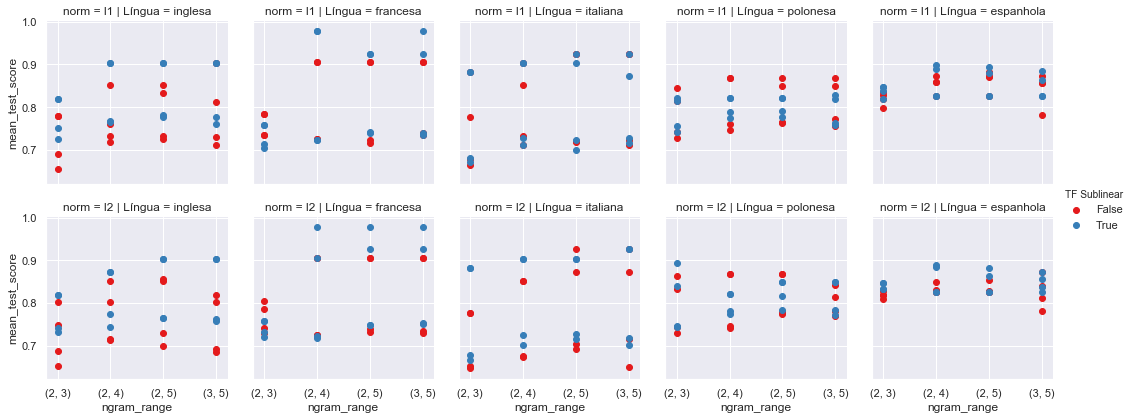

In [33]:
d = dfCV.copy()
d = d.rename(columns={'language':u'Língua', 'sublinear_tf':'TF Sublinear'})
d = d [ d.norm.isna() == False]
d['autorNumber'] = d.problem.map(lambda x: 20 if x % 2==0  else 5)
d.problem = d.apply(lambda x: x[u'Língua'] +" "+ str(x[u'problem']), axis=1)
#d.ngram_range = d.apply(lambda x: str(x[u'ngram_range'][0]) +" "+ str(x[u'ngram_range'][1]), axis=1)

d.std_test_score =d.std_test_score / d.std_test_score.quantile(0.95) *500;
d.std_test_score +=1;
d.std_test_score = d.std_test_score.astype(np.int64)
g = sns.FacetGrid(d, col='Língua', hue='TF Sublinear',  row="norm", height=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score").add_legend();
#sns.pairplot(d, hue="TF Sublinear", vars=["autorNumber", "mean_test_score"])


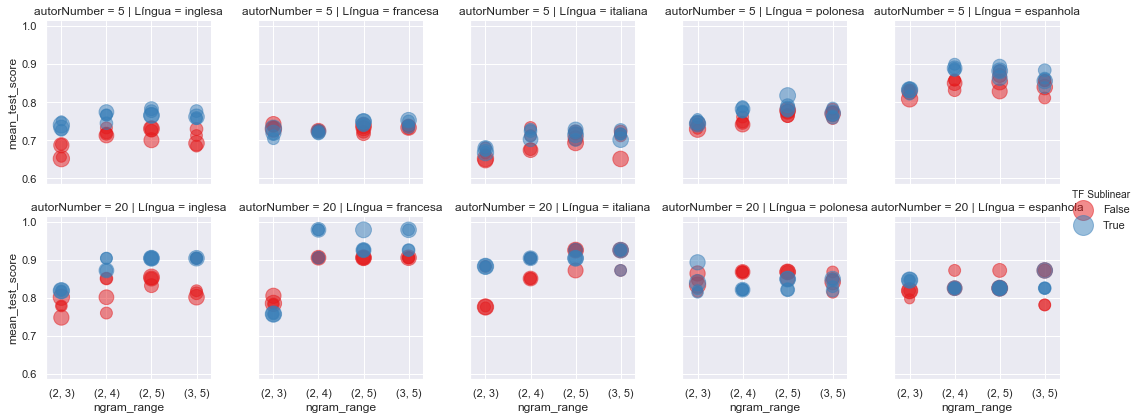

In [34]:
g = sns.FacetGrid(d, row='autorNumber', hue='TF Sublinear',  col=u"Língua", height=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score", alpha=0.5, s=d.std_test_score.values).add_legend();

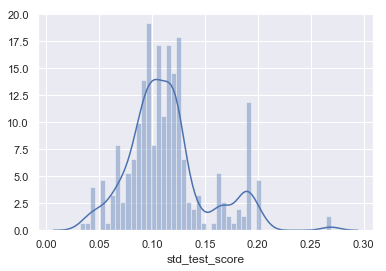

In [35]:
sns.distplot(dfCV.std_test_score, bins=50);

In [36]:
import statsmodels.api as sm

In [37]:
d = dfCV[['mean_test_score','problem', 'language','sublinear_tf','norm','ngram_range']].copy();
d.sublinear_tf=d.sublinear_tf.apply(lambda x: 1 if x else 0)
d['autorNumber'] = d.problem.map(lambda x: 20 if x % 2==0  else 5)
d.norm.fillna(value='None', inplace=True);

_, d['ngram_max'] = zip(*d.ngram_range.str.replace(r'[^\d,]','').str.split(',').values.tolist())
#d.ngram_min = d.ngram_min.astype(np.uint8);
d.ngram_max = d.ngram_max.astype(np.uint8);
d.drop(columns=['ngram_range','problem'], inplace=True)
#d['intercept'] = 1;

d=pd.get_dummies(d, columns=['language', 'norm'])

In [38]:
d.describe()

,mean_test_score,sublinear_tf,autorNumber,ngram_max,language_espanhola,language_francesa,language_inglesa,language_italiana,language_polonesa,norm_l1,norm_l2
count,320.0000,320.0000,320.0000,320.0000,320.0000,320.0000,320.0000,320.0000,320.0000,320.0000,320.0000
mean,0.8079,0.5000,12.5000,4.2500,0.2000,0.2000,0.2000,0.2000,0.2000,0.5000,0.5000
std,0.0760,0.5008,7.5117,0.8305,0.4006,0.4006,0.4006,0.4006,0.4006,0.5008,0.5008
min,0.6470,0.0000,5.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.7417,0.0000,5.0000,3.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.8187,0.5000,12.5000,4.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.5000
75%,0.8680,1.0000,20.0000,5.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
max,0.9787,1.0000,20.0000,5.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [39]:
mod = sm.OLS( d.iloc[:,0], d.iloc[:,1:])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        mean_test_score   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     59.98
Date:                Thu, 31 Jan 2019   Prob (F-statistic):           1.37e-58
Time:                        19:04:20   Log-Likelihood:                 520.59
No. Observations:                 320   AIC:                            -1023.
Df Residuals:                     311   BIC:                            -989.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
sublinear_tf           0.0208      0.005      3.857      0.000       0.010       0.031
autorNumber            0.0069      0.000     19.306      0.000       0.006       0.008
ngram_max              0.0213      0.003      6.558      0.000       0.015       0.028
language_espanhola     0.2118      0.007     30.725      0.000       0.198       0.225
language_francesa      0.1794      0.007     26.022      0.000       0.166       0.193
language_inglesa       0.1592      0.007     23.097      0.000       0.146       0.173
language_italiana      0.1623      0.007     23.540      0.000       0.149       0.176
language_polonesa      0.1731      0.007     25.111      0.000       0.160       0.187
norm_l1                0.4452      0.011     40.226      0.000       0.423       0.467
norm_l2                0.4406      0.011     39.813      0.000       0.419       0.462
==============================================================================
Omnibus:                        9.283   Durbin-Watson:                   0.561
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                4.891
Skew:                           0.021   Prob(JB):                       0.0867
Kurtosis:                       2.396   Cond. No.                     9.96e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.32e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

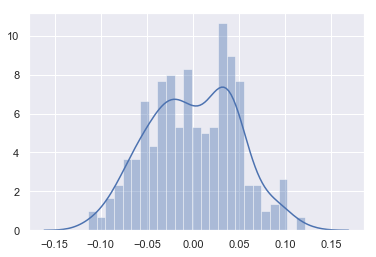

In [40]:
sns.distplot(res.predict()-d.iloc[:,0].values, bins=25)

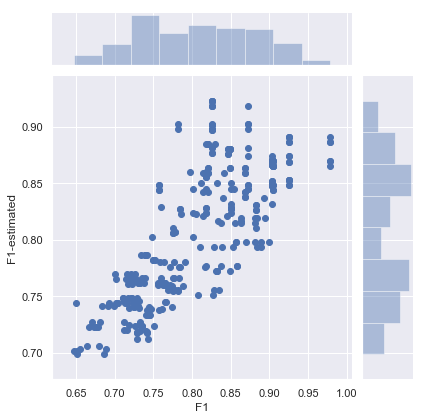

In [41]:
sns.jointplot(x='F1',y='F1-estimated',data=pd.DataFrame({'F1':d.iloc[:,0].values, 'F1-estimated':res.predict()}));